In [ ]:
import numpy as np
import jax.numpy as jnp
import jax
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from jax.nn.initializers import *
import quimb.tensor as qtn

from tn4ml.initializers import *
from tn4ml.models.mps import *
from tn4ml.models.model import *
from tn4ml.embeddings import *
from tn4ml.metrics import *
from tn4ml.strategy import *
from tn4ml.util import *

In [3]:
jax.config.update("jax_enable_x64", True)

# MNIST classification

### Load dataset

**MNIST images** &rarr; grayscale images
- size: 28x28
- 0-9 numbers

In [4]:
train, test = mnist.load_data()

In [6]:
train_labels = train[1]
train_images = train[0].reshape(-1, 28, 28)

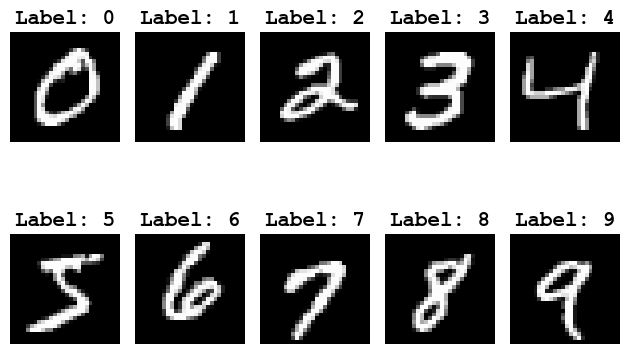

In [10]:
import matplotlib.pyplot as plt
hfont = {'fontname':'Courier New', 'fontsize': 15, 'fontweight': 'bold'}

for i in range(10):
    plt.subplot(2, 5, i + 1)
    # Select the first image of each digit
    digit_indices = np.where(train_labels == i)[0]
    plt.imshow(train_images[digit_indices[0]], cmap='gray')
    plt.title(f'Label: {i}', **hfont)
    plt.axis('off')

plt.tight_layout()
plt.savefig('mnist.pdf')

In [13]:
data = {"X": dict(train=train[0], test=test[0]), "y": dict(train=train[1], test=test[1])}

**Reduce size of the image**

In [14]:
strides = (2,2) # (2,2) for 14x14 images; (4,4) for 7x7 images
pool_size = (2,2)
pool = tf.keras.layers.MaxPooling2D(pool_size=pool_size, strides=strides, padding="same")

In [15]:
X_pooled = pool(tf.constant(data['X']['train'].reshape(-1,28,28,1))).numpy().reshape(-1,14,14)/255.0
X_pooled_test = pool(tf.constant(data['X']['test'].reshape(-1,28,28,1))).numpy().reshape(-1,14,14)/255.0

### Rearagne pixels in zig-zag order
- (from https://arxiv.org/pdf/1605.05775.pdf)

<img src="images/zig-zag.png" alt="MPS Params" width="150" height="150">

In [16]:
def zigzag_order(data):
    data_zigzag = []
    for x in data:
        image = []
        for i in x:
            image.extend(i)
        data_zigzag.append(image)
    return np.asarray(data_zigzag)

In [17]:
train_data = zigzag_order(X_pooled)
test_data = zigzag_order(X_pooled_test)

### Specify number of classes and hot-encode the labels

0 &rarr; [1 0 0 0 0 0 0 0 0 0]<br>
1 &rarr; [0 1 0 0 0 0 0 0 0 0]<br>
<br>
....<br>
<br>
9 &rarr; [0 0 0 0 0 0 0 0 0 1]<br>

In [18]:
n_classes = 10

In [19]:
y_train = integer_to_one_hot(data['y']['train'], n_classes)
y_test = integer_to_one_hot(data['y']['test'], n_classes)

**Take samples for training, validation and testing**

In [20]:
train_size = 6000
test_size = 5000
val_perc = 0.2

In [21]:
# take val_size samples from normal class for validation (X% of training data)
val_size = int(val_perc*train_size)
train_size = int(train_size - val_size)

In [22]:
indices = list(range(len(train_data)))
np.random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size : train_size+val_size]

# train data and validation inputs
train_inputs = np.take(train_data, train_indices, axis=0)
val_inputs = np.take(train_data, val_indices, axis=0)


# train data and validation labels
train_targets = np.take(y_train, train_indices, axis=0)
val_targets = np.take(y_train, val_indices, axis=0)

In [23]:
indices = list(range(len(test_data)))
np.random.shuffle(indices)

test_indices = indices[:test_size]

# test inputs
test_inputs = np.take(test_data, test_indices, axis=0)

# test labels
test_targets = np.take(y_test, test_indices, axis=0)

## TN as ML model
**Specify parameters and initialize a tensor network**

<img src="images/mps_params.png" alt="MPS Params" width="500" height="300">

In [24]:
L = 14*14 # number of tensors in the MPS
initializer = randn(1e-4) # MPS tensors are initialized with random normal values
key = jax.random.key(42)
shape_method = 'noteven'
bond_dim = 10 # bond dimension of the MPS
phys_dim = 3 # when polyomial embedding is used p = 3, when trigonometric embedding is used p = 2
class_dim = 10 # number of classes
index_class = L//2 if L%2==0 else L//2+1
cyclic = False
add_identity = True
boundary = 'obc' # open boundary conditions

In [25]:
model = MPS_initialize(L,
                    initializer=initializer,
                    key=key,
                    shape_method=shape_method,
                    bond_dim=bond_dim,
                    phys_dim=phys_dim,
                    cyclic=False,
                    add_identity=True,
                    class_dim=class_dim,
                    class_index=index_class,
                    boundary=boundary,
                    dtype=jnp.float64)

**Define training parameters**

In [27]:
def cross_entropy_loss(*args, **kwargs):
    return loss_wrapper_optax(optax.softmax_cross_entropy)(*args, **kwargs).mean()

In [28]:
# training parameters
optimizer = optax.adam
strategy = 'global' # Global Gradient Descent
loss = cross_entropy_loss
train_type = 1 # 0 for unsupervised, 1 for supervised
embedding = polynomial(degree=2) # if using randn
learning_rate = 1e-4

In [29]:
model.configure(optimizer=optimizer, strategy=strategy, loss=loss, train_type=train_type, learning_rate=learning_rate)

In [30]:
epochs = 50
batch_size = 256

To obtain loss scalar value, contract:

<div style="text-align: center;">
    <img src="images/mps_models.png" alt="MPS Params" width="150" height="250">
</div>

In [31]:
history = model.train(train_inputs,
                    targets = train_targets,
                    val_inputs = val_inputs,
                    val_targets = val_targets,
                    epochs = epochs,
                    batch_size = batch_size,
                    embedding = embedding,
                    normalize = True,
                    cache=False, # for now True not working for classification
                    display_val_acc=True,
                    val_batch_size=64,
                    dtype = jnp.float64)

epoch: 100%|██████████| 50/50 [16:48<00:00, 20.17s/it, loss=1.4641107822965358, val_loss=1.4994329660644499, val_acc=0.943]


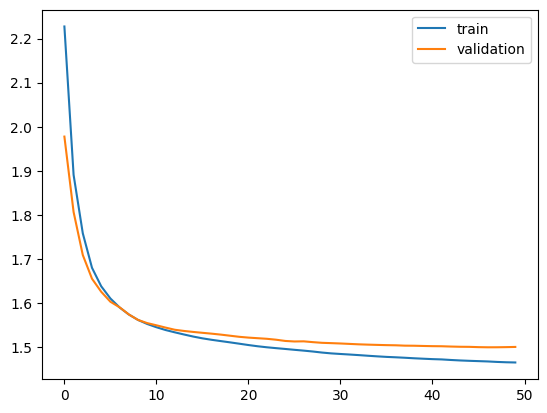

In [32]:
import matplotlib.pyplot as plt
# plot loss
plt.figure()
plt.plot(range(len(model.history['loss'])), model.history['loss'], label='train')
plt.plot(range(len(model.history['val_loss'])), model.history['val_loss'], label='validation')
plt.legend()
plt.show()

**Save model**

In [33]:
model.save('model', 'tests/mnist_class', tn=True)

### Evaluate

Calculate accuracy of the classification

In [34]:
model.accuracy(test_inputs, test_targets, embedding=embedding, batch_size=64)

0.9439102564102564